In [1]:
from math import *
from numpy import sign

import numpy as np
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib
import matplotlib.cbook 
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random as rand

from matplotlib import rc


rc('text', usetex=True)
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=20)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=20)

matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{graphics,graphicx,rotating}'
]

%matplotlib inline  



/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
num=1000
def get(num):
    ! cd ntuple_Tchannel
    mylist=! ls ntuple_Tchannel/tchannel_up_$num*.evt
    return mylist

get(1000)

['ntuple_Tchannel/tchannel_up_1000_rinv0.01.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.1.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.2.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.3.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.4.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.5.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.6.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.7.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.8.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.98.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.99.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.9.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv1.0.evt']

### Read input

In [4]:
def readfile(name, folder='ntuple_Tchannel/', lumi=1, cxn=None):
    data = pd.read_csv(folder+name+'.evt', header=0, delimiter=',', skipinitialspace=True)
    data.meta = pd.read_csv(folder+name+'.meta', header=0, delimiter=',', skipinitialspace=True)
    if 'weight' in data.columns:
        data['weight'] *= (data.meta['cxn']*lumi/data.meta['sum_weight'])[0]
    else:
        data['weight'] = (data.meta['cxn']*lumi / data.meta['nevt'])[0]  
    if cxn is not None:
        data['weight'] = (cxn*lumi / data.meta['nevt'])[0]  
    return data

bkg = ['bkg_ttbar_dilep_0',  'bkg_ttbar_semilep_0',  'bkg_Wj_0',  'bkg_Zj_0']
bkg = [ readfile(f,folder='ntuple_Zprime/') for f in bkg ]

def nbkg(cut, lumi=37*1000):
    mybkg = [ f.query(cut) for f in bkg ]
    myevt = np.asarray([ lumi*np.sum(f['weight']) for f in mybkg ])
    return myevt

b = 10**np.linspace(log10(500),log10(10000),101)

cxn3000= .03951
cxn5000= .0103

def get_sig(mass):
    sigup = ['tchannel_up_mass_rinv0.01',
        'tchannel_up_mass_rinv0.1',
        'tchannel_up_mass_rinv0.2',
        'tchannel_up_mass_rinv0.3',
        'tchannel_up_mass_rinv0.4',
        'tchannel_up_mass_rinv0.5',
        'tchannel_up_mass_rinv0.6',
        'tchannel_up_mass_rinv0.7',
        'tchannel_up_mass_rinv0.8',
        'tchannel_up_mass_rinv0.9',
        'tchannel_up_mass_rinv0.98',
        'tchannel_up_mass_rinv0.99',
        'tchannel_up_mass_rinv1.0'
        ]
    
    sigdown = ['tchannel_down_mass_rinv0.01',
        'tchannel_down_mass_rinv0.1',
        'tchannel_down_mass_rinv0.2',
        'tchannel_down_mass_rinv0.3',
        'tchannel_down_mass_rinv0.4',
        'tchannel_down_mass_rinv0.5',
        'tchannel_down_mass_rinv0.6',
        'tchannel_down_mass_rinv0.7',
        'tchannel_down_mass_rinv0.8',
        'tchannel_down_mass_rinv0.9',
        'tchannel_down_mass_rinv0.98',
        'tchannel_down_mass_rinv0.99',
        'tchannel_down_mass_rinv1.0'
        ]
    
    sigup = [ s.replace('mass',str(mass)) for s in sigup ]
    sigdown = [ s.replace('mass',str(mass)) for s in sigdown ]
    
    sigup = [ readfile(f) for f in sigup ]
    sigup_cxn = [ f.meta['cxn'] for f in sigup ]
    
    sigdown = [ readfile(f) for f in sigdown ]
    sigdown_cxn = [ f.meta['cxn'] for f in sigdown ]
    
    #sig_Mt = [ np.histogram(f['Mt'],bins=b,weights=f['weight'])[0] for f in sigup ]
    return [ sigup, sigdown ]



def get_sig_pair(mass):
    sig = [
            'pair_prod_mass_rinv0.01',
            'pair_prod_mass_rinv0.1',
            'pair_prod_mass_rinv0.2',
            'pair_prod_mass_rinv0.3',
            'pair_prod_mass_rinv0.4',
            'pair_prod_mass_rinv0.5',
            'pair_prod_mass_rinv0.6',
            'pair_prod_mass_rinv0.7',
            'pair_prod_mass_rinv0.8',
            'pair_prod_mass_rinv0.98',
            'pair_prod_mass_rinv0.99',
            'pair_prod_mass_rinv1.0',
        ]
        
    sig = [ s.replace('mass',str(mass)) for s in sig ]
    sig = [ readfile(f) for f in sig ]

    sig_cxn = [ f.meta['cxn'] for f in sig ]
    
    
    #sig_Mt = [ np.histogram(f['Mt'],bins=b,weights=f['weight'])[0] for f in sigup ]
    return sig

sig1000=get_sig(1000)
sig5000=get_sig(5000)
sig1000_pair = get_sig_pair(1000)
sig3000_pair = get_sig_pair(3000)
sig5000_pair = get_sig_pair(5000)

In [7]:
def nsig(sig, cut, lumi=37*1000, mix=[4./(4./3 *.59)**2 , 4./(2./3 *.59)**2]):
    [ sig1, sig2 ] = sig
    mysig1 = [ f.query(cut) for f in sig1 ]
    mysig2 = [ f.query(cut) for f in sig2 ]
    
    myevt1 = np.asarray([ mix[0]*lumi*np.sum(f['weight']) for f in mysig1 ])
    myevt2 = np.asarray([ mix[1]*lumi*np.sum(f['weight']) for f in mysig2 ])
    
    return myevt1+myevt2

def nsig_pair(sig, cut, lumi=37*1000):
    mysig = [ f.query(cut) for f in sig ]
    
    myevt = np.asarray([ 2*2*2*lumi*np.sum(f['weight']) for f in mysig ])
    return myevt

In [23]:
cutlist1=['MEt > 1000 & dphi <.4', 'MEt > 1200 & dphi <.4', 
          'MEt > 1000 & dphi <.4 & pt3 > 100', 'MEt > 1200 & dphi <.4 & pt3 > 100',
          'MEt > 1000 & dphi <.4 & pt3 > 120', 'MEt > 1200 & dphi <.4 & pt3 > 120',
         ]

cutlist2=['MEt > 800 & dphi >.4', 'MEt > 1000 & dphi >.4', 'MEt > 1200 & dphi >.4',
          'MEt > 800 & dphi >.4 & pt3 > 100', 'MEt > 1000 & dphi >.4 & pt3 > 100', 'MEt > 1200 & dphi >.4 & pt3 > 100',
          'MEt > 800 & dphi >.4 & pt3 > 120', 'MEt > 1000 & dphi >.4 & pt3 > 120', 'MEt > 1200 & dphi >.4 & pt3 > 120'        
         ]

cutlist1_pair=['MEt > 1000 & dphi <.4 & pt4 > 80', 'MEt > 1200 & dphi <.4 & pt4 > 80', 
          'MEt > 1000 & dphi <.4 & pt4 > 100', 'MEt > 1200 & dphi <.4 & pt4 > 100',
          'MEt > 1000 & dphi <.4 & pt4 > 110', 'MEt > 1200 & dphi <.4 & pt4 > 110',
         ]

cutlist2_pair=['MEt > 800 & dphi >.4 & pt4 > 80', 'MEt > 1000 & dphi >.4 & pt4 > 80', 'MEt > 1200 & dphi >.4 & pt4 > 80',
          'MEt > 800 & dphi >.4 & pt4 > 100', 'MEt > 1000 & dphi >.4 & pt4 > 100', 'MEt > 1200 & dphi >.4 & pt4 > 100',
          'MEt > 800 & dphi >.4 & pt4 > 110', 'MEt > 1000 & dphi >.4 & pt4 > 110', 'MEt > 1200 & dphi >.4 & pt4 > 110'        
         ]


commoncut=' & pt3 > 80'

cutnbkg1=[ np.sum(nbkg(c+commoncut)) for c in cutlist1 ]
cutnbkg2=[ np.sum(nbkg(c+commoncut)) for c in cutlist2 ]
cutnbkg1_pair=[ np.sum(nbkg(c+commoncut)) for c in cutlist1_pair ]
cutnbkg2_pair=[ np.sum(nbkg(c+commoncut)) for c in cutlist2_pair ]


cutnsig1=[ nsig(sig1000, c+commoncut) for c in cutlist1 ]
cutnsig2=[ nsig(sig1000, c+commoncut) for c in cutlist2 ]
cutnsig1_5000=[ nsig(sig5000, c+commoncut) for c in cutlist1 ]
cutnsig2_5000=[ nsig(sig5000, c+commoncut) for c in cutlist2 ]

cutnsig1_1000_pair=[ nsig_pair(sig1000_pair, c+commoncut) for c in cutlist1_pair ]
cutnsig2_1000_pair=[ nsig_pair(sig1000_pair, c+commoncut) for c in cutlist2_pair ]
cutnsig1_5000_pair=[ nsig_pair(sig5000_pair, c+commoncut) for c in cutlist1_pair ]
cutnsig2_5000_pair=[ nsig_pair(sig5000_pair, c+commoncut) for c in cutlist2_pair ]


from scipy.optimize import bisect
def limit(nbkg):
    
    def func_root(x):
        logpart = x-nbkg*np.log(1+x/nbkg)
        my_val = logpart - 2.0
        return my_val
    
    soln = bisect(func_root, 0,10*nbkg)
    return soln

def limit_list(nbkg):
    return np.asarray([ limit(n) for n in nbkg ])

cutlim1 = [ limit(n) for n in cutnbkg1 ]
cutlim2 = [ limit(n) for n in cutnbkg2 ]
cutlim1_pair = [ limit(n) for n in cutnbkg1_pair ]
cutlim2_pair = [ limit(n) for n in cutnbkg2_pair ]


exc_sig_factor1 = np.asarray([ cutlim1[i]/l for i,l in enumerate(cutnsig1)])
exc_sig_factor2 = np.asarray([ cutlim2[i]/l for i,l in enumerate(cutnsig2)])
exc_sig_factor1_5000 = np.asarray([ cutlim1[i]/l for i,l in enumerate(cutnsig1_5000)])
exc_sig_factor2_5000 = np.asarray([ cutlim2[i]/l for i,l in enumerate(cutnsig2_5000)])

exc_sig_factor1_1000_pair = np.asarray([ cutlim1_pair[i]/l for i,l in enumerate(cutnsig1_1000_pair)])
exc_sig_factor2_1000_pair = np.asarray([ cutlim2_pair[i]/l for i,l in enumerate(cutnsig2_1000_pair)])
exc_sig_factor1_5000_pair = np.asarray([ cutlim1_pair[i]/l for i,l in enumerate(cutnsig1_5000_pair)])
exc_sig_factor2_5000_pair = np.asarray([ cutlim2_pair[i]/l for i,l in enumerate(cutnsig2_5000_pair)])


exc_sig_factor1 = np.amin(exc_sig_factor1, axis=0)
exc_sig_factor2 = np.amin(exc_sig_factor2, axis=0)
exc_sig_factor1_5000 = np.amin(exc_sig_factor1_5000, axis=0)
exc_sig_factor2_5000 = np.amin(exc_sig_factor2_5000, axis=0)

exc_sig_factor1_1000_pair = np.amin(exc_sig_factor1_1000_pair, axis=0)
exc_sig_factor2_1000_pair = np.amin(exc_sig_factor2_1000_pair, axis=0)
exc_sig_factor1_5000_pair = np.amin(exc_sig_factor1_5000_pair, axis=0)
exc_sig_factor2_5000_pair = np.amin(exc_sig_factor2_5000_pair, axis=0)


cutoff1 = 1000./exc_sig_factor1**(1./4)
cutoff2 = 1000./exc_sig_factor2**(1./4)
cutoff1_5000 = 5000./exc_sig_factor1_5000**(1./4)
cutoff2_5000 = 5000./exc_sig_factor2_5000**(1./4)

cutoff1_1000_pair = 1000./exc_sig_factor1_1000_pair**(1./4)
cutoff2_1000_pair = 1000./exc_sig_factor2_1000_pair**(1./4)
cutoff1_5000_pair = 5000./exc_sig_factor1_5000_pair**(1./4)
cutoff2_5000_pair = 5000./exc_sig_factor2_5000_pair**(1./4)



In [29]:
print(cutoff1)
print(cutoff1_1000_pair)
print(cutoff2_1000_pair)

print(cutoff1_5000_pair)
print(cutoff2_5000_pair)

[ 294.03663308  567.44840705  708.29653928  806.77918334  879.09730996
  916.85873811  933.02266067  908.02556663  854.66895525  716.61769515
  459.03150834  389.297541    256.79011121]
[ 381.1266407   596.49542841  677.74965777  737.22714184  810.60010275
  887.96792278  933.65154757  982.69804542  899.31063733  855.38587751
  933.65154757  848.40255153]
[  315.44034222   530.50530599   783.18278794   870.95823718  1004.12084901
  1133.29149629  1231.72095128  1357.40777932  1497.24316799  1694.0966787
  1693.70183036  1681.72581299]
[ 17.66025192  33.67556825  40.440135    45.36936343  48.79397825
  50.5327511   50.9006222   50.19754878  48.0784187   36.54102622
  34.76531171  32.74432591]
[ 11.15396504  23.09766889  30.78862014  36.33495193  41.20071566
  45.22653738  48.42510685  50.52411988  51.38935857  47.54221578
  46.93497643  46.58935011]


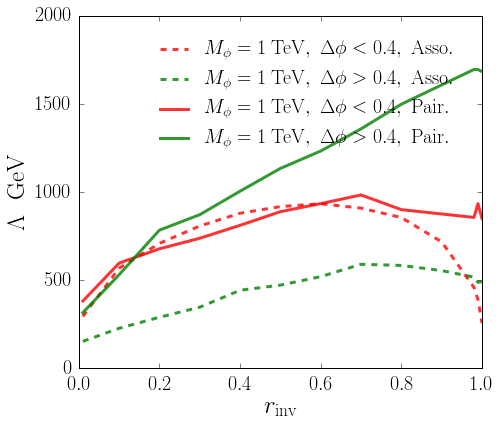

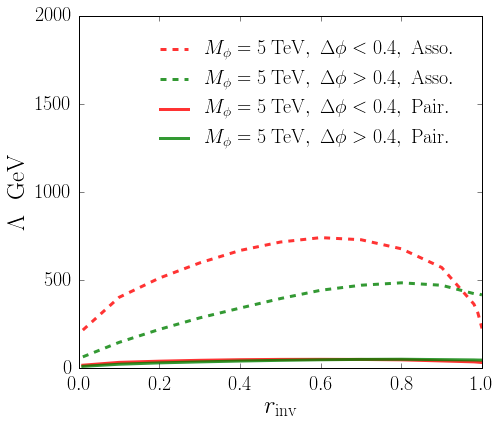

In [28]:
plt.figure()

fig=plt.figure("m", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

rinv_pair=[.01,.1,.2,.3,.4,.5,.6,.7,.8,.98,.99,1]

rinv=[.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.98,.99,1]

plt.plot(rinv,cutoff1,label=r'$M_\phi = 1\;{\rm TeV},\; \Delta \phi < 0.4,\;{\rm Asso.}$',
         lw=3,alpha=.8,c='red',ls='--')
plt.plot(rinv,cutoff2,label=r'$M_\phi = 1\;{\rm TeV},\; \Delta \phi > 0.4,\;{\rm Asso.}$',
         lw=3,alpha=.8,c='green',ls='--')

plt.plot(rinv_pair,cutoff1_1000_pair,label=r'$M_\phi = 1\;{\rm TeV},\; \Delta \phi < 0.4,\;{\rm Pair.}$',
         lw=3,alpha=.8,c='red')

plt.plot(rinv_pair,cutoff2_1000_pair,label=r'$M_\phi = 1\;{\rm TeV},\; \Delta \phi > 0.4,\;{\rm Pair.}$',
         lw=3,alpha=.8,c='green')



plt.ylim([0,2000])
plt.xlabel(r'$ r_{\rm inv}$', fontsize=25)
plt.ylabel(r'$ \Lambda\,\,{\rm\; GeV}$', fontsize=25)

plt.legend(bbox_to_anchor=(0, 0, .95, 0.95),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5, columnspacing=.8,
           borderaxespad=0.)

plt.savefig("cutoff_tchannel_associated_1000.pdf")


plt.figure()

fig=plt.figure("5000", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

rinv=[.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.98,.99,1]

plt.plot(rinv,cutoff1_5000,label=r'$M_\phi = 5\;{\rm TeV},\; \Delta \phi < 0.4,\;{\rm Asso.}$',
         lw=3,alpha=.8,c='red',ls='--')
plt.plot(rinv,cutoff2_5000,label=r'$M_\phi = 5\;{\rm TeV},\; \Delta \phi > 0.4,\;{\rm Asso.}$',
         lw=3,alpha=.8,c='green',ls='--')

plt.plot(rinv_pair,cutoff1_5000_pair,label=r'$M_\phi = 5\;{\rm TeV},\; \Delta \phi < 0.4,\;{\rm Pair.}$',
         lw=3,alpha=.8,c='red')

plt.plot(rinv_pair,cutoff2_5000_pair,label=r'$M_\phi = 5\;{\rm TeV},\; \Delta \phi > 0.4,\;{\rm Pair.}$',
         lw=3,alpha=.8,c='green')


plt.ylim([0,2000])
plt.xlabel(r'$ r_{\rm inv}$', fontsize=25)
plt.ylabel(r'$ \Lambda\,\,{\rm\; GeV}$', fontsize=25)

plt.legend(bbox_to_anchor=(0, 0, .95, 0.95),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5, columnspacing=.8,
           borderaxespad=0.)

plt.savefig("cutoff_tchannel_associated_5000.pdf")

In [32]:
print("Cutoff Limits for 1 TeV t-channel, same order as legend")
print(cutoff1)
print(cutoff2)
print(cutoff1_1000_pair)
print(cutoff2_1000_pair)

print(" ")
print("Cutoff Limits for 5 TeV t-channel, same order as legend")
print(cutoff1_5000)
print(cutoff2_5000)
print(cutoff1_5000_pair)
print(cutoff2_5000_pair)

Cutoff Limits for 1 TeV t-channel, same order as legend
[ 294.03663308  567.44840705  708.29653928  806.77918334  879.09730996
  916.85873811  933.02266067  908.02556663  854.66895525  716.61769515
  459.03150834  389.297541    256.79011121]
[ 152.7350868   226.7698984   289.4608086   346.39789009  442.47342879
  471.55718805  519.89008878  589.68660891  583.20256407  553.95620026
  516.79244831  487.48598757  491.30101899]
[ 381.1266407   596.49542841  677.74965777  737.22714184  810.60010275
  887.96792278  933.65154757  982.69804542  899.31063733  855.38587751
  933.65154757  848.40255153]
[  315.44034222   530.50530599   783.18278794   870.95823718  1004.12084901
  1133.29149629  1231.72095128  1357.40777932  1497.24316799  1694.0966787
  1693.70183036  1681.72581299]
 
Cutoff Limits for 5 TeV t-channel, same order as legend
[ 216.74256499  402.51164068  511.7285209   597.64235834  668.1290737
  715.80941127  740.85150479  728.89329634  677.46855772  571.57997447
  363.77358763  31